<a href="https://colab.research.google.com/github/KaxitPandya/699-Project/blob/main/ECE_699A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# importing variables from json:
import json
with open('./input copy.json', 'r') as f:
    input_data = json.load(f)

In [9]:
!pip install pydot graphviz visualkeras


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Model Training

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = pd.read_csv(input_data['dataset_path2'])

X = data.drop("Target", axis=1).values
y = data["Target"].values

# Normalize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Split into training and testing datasets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [12]:
# 2. Define the Sparse Autoencoder Model in TensorFlow/Keras
r2_score_list = []
mae_list = []
mse_list = []
rmse_list = []

for i in range(5):
    # Split into training and testing datasets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42+i)
    
    input_dim = X_train.shape[1]
    latent_dim = 64  # tune this based on dataset
    
    #input
    input_layer = keras.Input(shape=(input_dim,))
    
    # Encoder
    encoded = layers.Dense(128, activation='relu')(input_layer)
    # Latent representation with L1 activity regularization to encourage sparsity
    latent = layers.Dense(latent_dim, activation='relu',
                          activity_regularizer=regularizers.l1(1e-3))(encoded)
    
    # Decoder
    decoded = layers.Dense(128, activation='relu')(latent)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)  # Use linear activation for reconstruction
    
    # Autoencoder model
    autoencoder = keras.Model(inputs=input_layer, outputs=decoded, name="sparse_autoencoder")
    autoencoder.compile(optimizer='adam', loss='mse')
    
    #autoencoder.summary()
    # Training the autoencoder
    epochs = 200
    batch_size = 8
    
    history = autoencoder.fit(X_train, X_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_split=0.1,verbose=0)
    # 4. Create the Encoder Model for Feature Extraction
    # Create a model to extract the latent features
    encoder = keras.Model(inputs=input_layer, outputs=latent, name="encoder")
    latent_train = encoder.predict(X_train)
    latent_test = encoder.predict(X_test)
    
    
    ###Let's do RF model using latent_train
    from sklearn.ensemble import RandomForestRegressor as RFR
    mymodel = RFR(random_state=97)
    mymodel.fit(latent_train, y_train)
    y_pred = mymodel.predict(latent_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Append metrics to lists
    r2_score_list.append(r2)
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)

# Print average metrics across all folds
m1_r2 = np.mean(r2_score_list)
m1_mae = np.mean(mae_list)
m1_mse = np.mean(mse_list)
m1_rmse = np.mean(rmse_list)
print(f"Average R² Score: {np.mean(r2_score_list):.4f} ± {np.std(r2_score_list):.4f}")
print(f"Average MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"Average MSE: {np.mean(mse_list):.4f} ± {np.std(mse_list):.4f}")
print(f"Average RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")

# Return all metric lists
r2_score_list, mae_list, mse_list, rmse_list

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Average R² Score: 0.1022 ± 0.1645
Average MAE: 102.7856 ± 12.3171
Average MSE: 17515.2852 ± 3095.6341
Average RMSE: 131.8032 ± 11.9668


([0.01731174893370946,
  0.12433495755949397,
  0.02633568937026054,
  0.40836330939716103,
  -0.06555868002575549],
 [106.63469850000003,
  93.41987869047618,
  108.94343505782311,
  84.88789216071427,
  120.04189017857142],
 [18276.337624918157,
  15434.107805273585,
  19789.381986158136,
  12715.238727672242,
  21361.359834082403],
 [np.float64(135.19000563990727),
  np.float64(124.23408471620654),
  np.float64(140.67473826582417),
  np.float64(112.76186734739827),
  np.float64(146.1552593445833)])

## Sparse Autoencoder + Random Forest Model Visualizations

c:\Users\kaxit\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


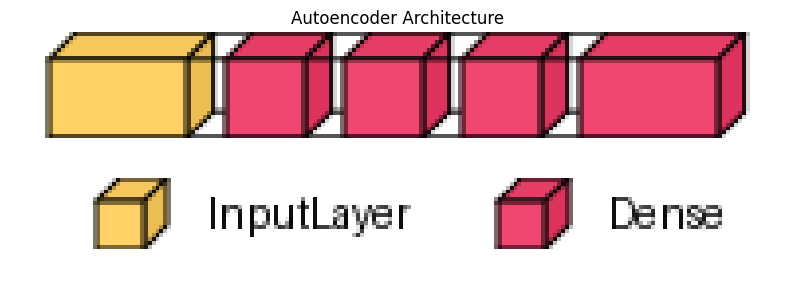

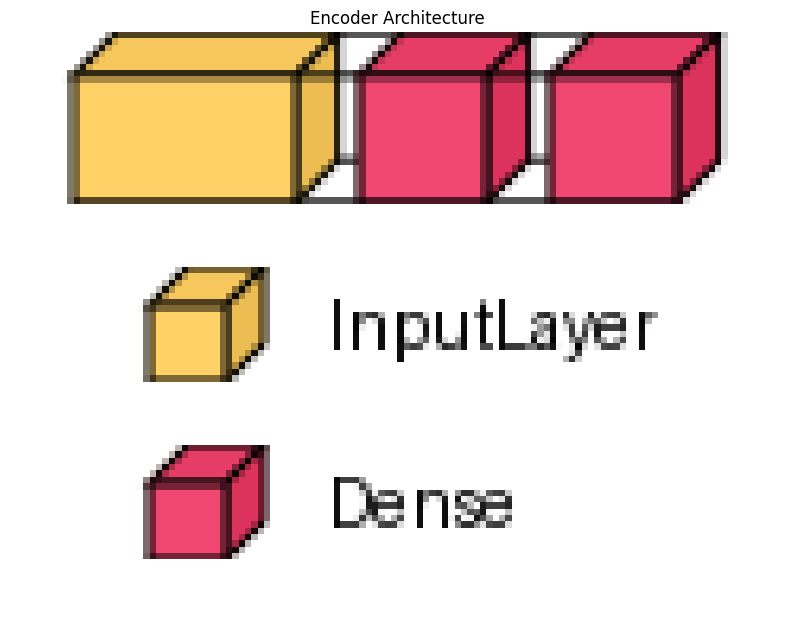

In [13]:
import os
import visualkeras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Create a directory for figures if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Visualize and save the autoencoder architecture
autoencoder_img_path = 'figures/autoencoder_architecture_visualkeras.png'
visualkeras.layered_view(autoencoder, to_file=autoencoder_img_path, legend=True)
autoencoder_img = image.load_img(autoencoder_img_path)
plt.figure(figsize=(10, 10))
plt.imshow(autoencoder_img)
plt.axis('off')
plt.title('Autoencoder Architecture')
plt.show()

# Visualize and save the encoder architecture
encoder_img_path = 'figures/encoder_architecture_visualkeras.png'
visualkeras.layered_view(encoder, to_file=encoder_img_path, legend=True)
encoder_img = image.load_img(encoder_img_path)
plt.figure(figsize=(10, 10))
plt.imshow(encoder_img)
plt.axis('off')
plt.title('Encoder Architecture')
plt.show()

In [14]:
# import os
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from tensorflow.keras.utils import plot_model

# # Suppose your model is named "model"
# # Create a directory for figures if it doesn't exist
# os.makedirs('figures', exist_ok=True)

# # Generate and save the plot
# plot_model(
#     encoder,
#     to_file='figures/model_architecture.png',
#     show_shapes=True,        # show input/output shapes
#     show_layer_names=True,   # show layer names
#     rankdir='TB'             # 'TB' for top-to-bottom; 'LR' for left-to-right
# )

# # Display the saved image
# img = mpimg.imread('figures/model_architecture.png')
# plt.figure(figsize=(8, 8))
# plt.imshow(img)
# plt.axis('off')
# plt.title('Model Architecture')
# plt.show()


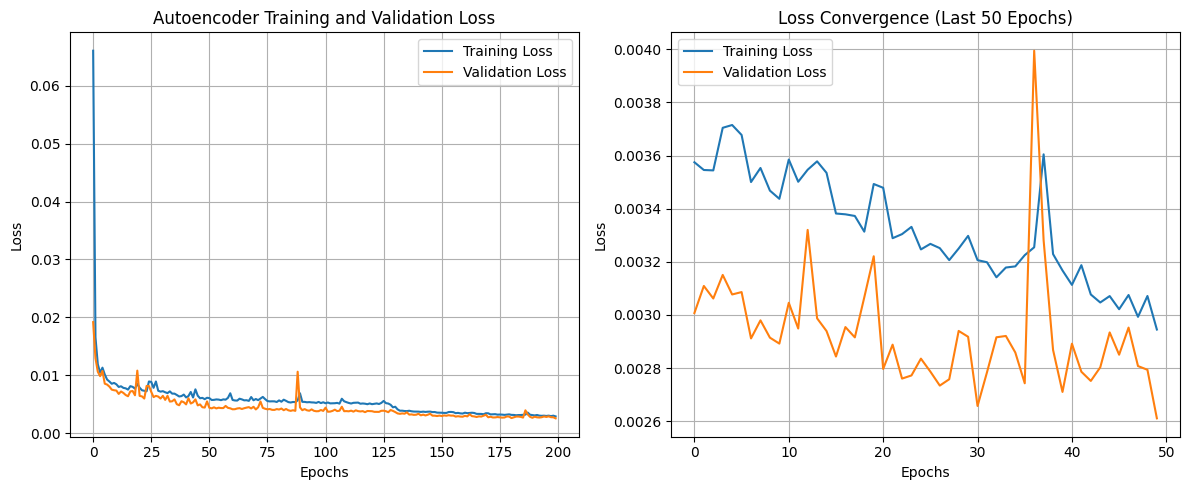

In [15]:
# Visualize Autoencoder Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot convergence by zooming in on the final epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][-50:], label='Training Loss')
plt.plot(history.history['val_loss'][-50:], label='Validation Loss')
plt.title('Loss Convergence (Last 50 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/autoencoder_training_history.png', dpi=300)
plt.show()

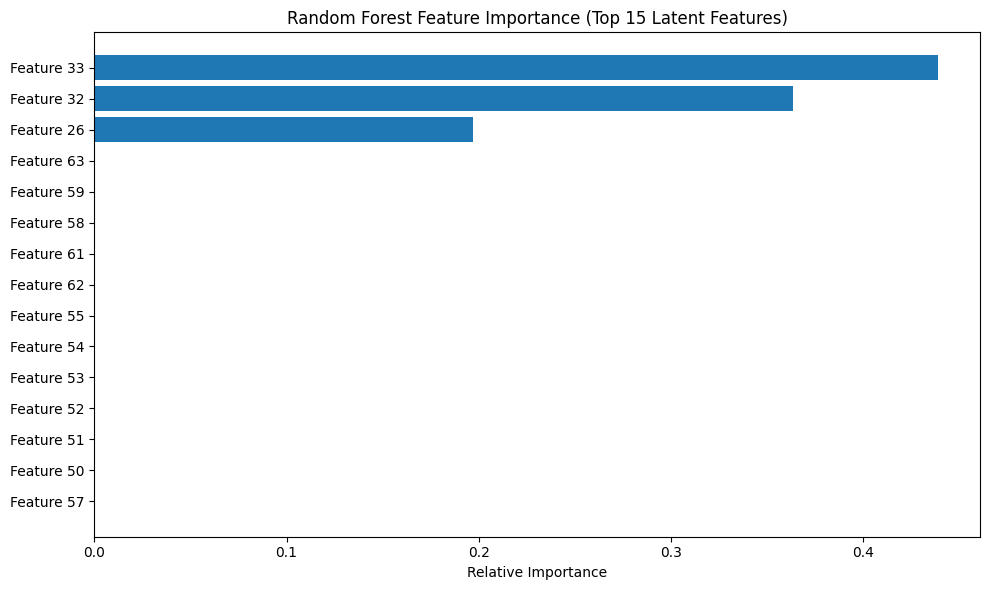

In [16]:
# Visualize Random Forest Feature Importance
plt.figure(figsize=(10, 6))
feature_importances = mymodel.feature_importances_
indices = np.argsort(feature_importances)[-15:]  # Show top 15 features

plt.barh(range(len(indices)), feature_importances[indices])
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.title('Random Forest Feature Importance (Top 15 Latent Features)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.savefig('figures/rf_feature_importance.png', dpi=300)
plt.show()

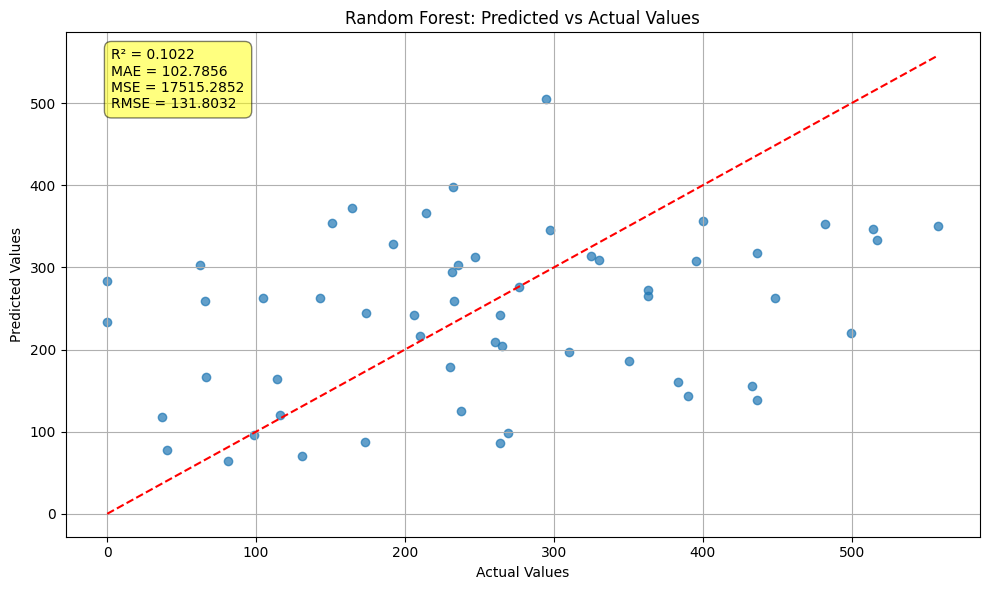

In [17]:
# Visualize Predicted vs Actual Values for Random Forest Model
plt.figure(figsize=(10, 6))

# Plot predicted vs actual
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.title('Random Forest: Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Add performance metrics to the plot
plt.annotate(f'R² = {m1_r2:.4f}\nMAE = {m1_mae:.4f}\nMSE = {m1_mse:.4f}\nRMSE = {m1_rmse:.4f}', 
             xy=(0.05, 0.85), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.5))

plt.grid(True)
plt.tight_layout()
plt.savefig('figures/rf_predicted_vs_actual.png', dpi=300)
plt.show()

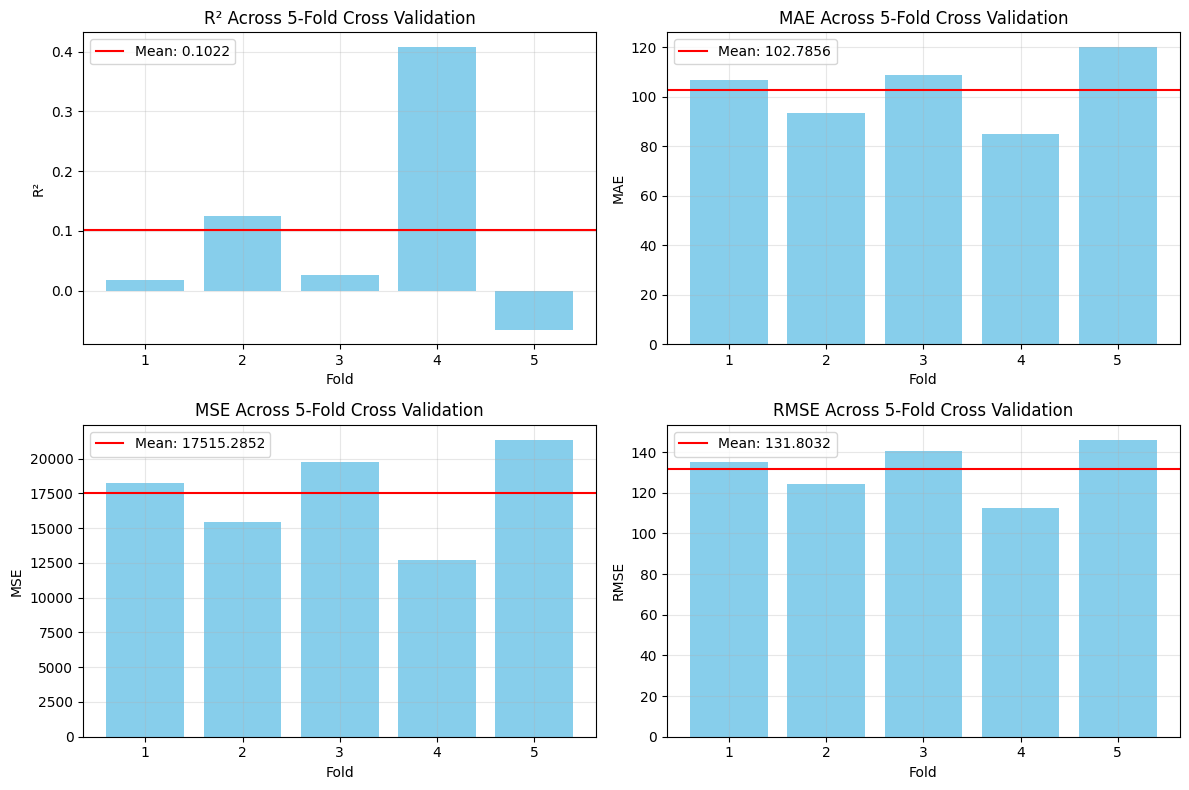

In [18]:
# Visualize Random Forest Metrics Across Cross-Validation Folds
plt.figure(figsize=(12, 8))

metrics = ['R²', 'MAE', 'MSE', 'RMSE']
metric_values = [r2_score_list, mae_list, mse_list, rmse_list]

for i, (metric, values) in enumerate(zip(metrics, metric_values), 1):
    plt.subplot(2, 2, i)
    plt.bar(range(1, 6), values, color='skyblue')
    plt.axhline(y=np.mean(values), color='r', linestyle='-', label=f'Mean: {np.mean(values):.4f}')
    plt.title(f'{metric} Across 5-Fold Cross Validation')
    plt.xlabel('Fold')
    plt.ylabel(metric)
    plt.xticks(range(1, 6))
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/rf_cv_metrics.png', dpi=300)
plt.show()

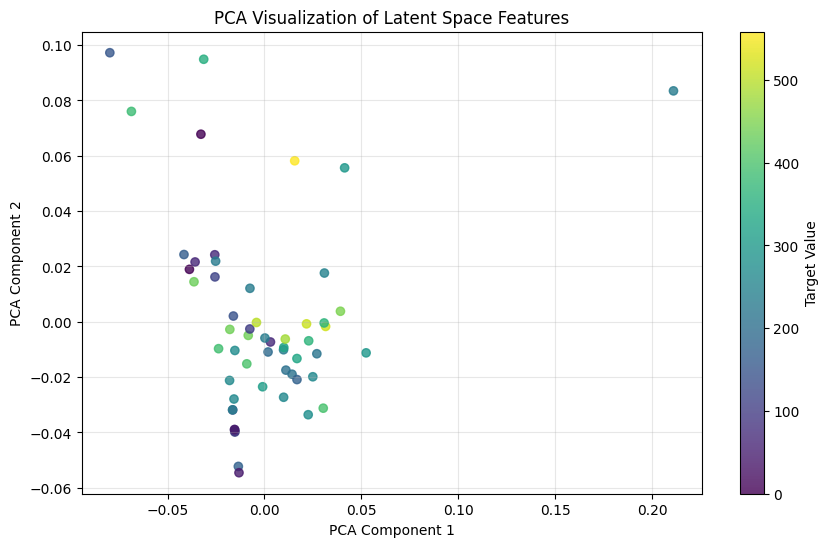

In [19]:
# Visualize Latent Space Features
from sklearn.decomposition import PCA

# Apply PCA to visualize high-dimensional latent space in 2D
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_test)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=y_test, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, label='Target Value')
plt.title('PCA Visualization of Latent Space Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True, alpha=0.3)
plt.savefig('figures/latent_space_pca.png', dpi=300)
plt.show()

In [20]:
import matplotlib.pyplot as plt 

In [21]:
# 5. Build and Train a Downstream Regression Model for AGB Prediction
r2_score_list2 = []
mae_list2 = []
mse_list2 = []
rmse_list2 = []

for i in range(5):
    # Split into training and testing datasets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42+i)
    latent_train = encoder.predict(X_train)
    latent_test = encoder.predict(X_test)
    
    reg_input = keras.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(reg_input)
    x = layers.Dense(32, activation='relu')(x)
    # Single output neuron for regression (AGB value)
    reg_output = layers.Dense(1, activation='linear')(x)
    regressor = keras.Model(inputs=reg_input, outputs=reg_output, name="regressor")
    
    regressor.compile(optimizer='adam', loss='mse', metrics=['mae'])
    #regressor.summary()
    
    reg_epochs = 300
    reg_history = regressor.fit(latent_train, y_train,
                                epochs=reg_epochs,
                                batch_size=8,
                                validation_split=0.1,
                                verbose=0)  # Set verbose=1 to see training progress
    
    y_pred = regressor.predict(latent_test).flatten()
    
    # Calculate metrics
    mae_value = mean_absolute_error(y_test, y_pred)
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2 = r2_score(y_test, y_pred)
    
    # Store metrics in lists
    mae_list2.append(mae_value)
    mse_list2.append(mse_value)
    rmse_list2.append(rmse_value)
    r2_score_list2.append(r2)

# Calculate and print average metrics
print("Average Results Across All Folds:")
print(f"  Mean R^2: {np.mean(r2_score_list2):.4f} ± {np.std(r2_score_list2):.4f}")
print(f"  Mean MAE: {np.mean(mae_list2):.4f} ± {np.std(mae_list2):.4f}")
print(f"  Mean MSE: {np.mean(mse_list2):.4f} ± {np.std(mse_list2):.4f}")
print(f"  Mean RMSE: {np.mean(rmse_list2):.4f} ± {np.std(rmse_list2):.4f}")
m2_r2 = np.mean(r2_score_list2)
m2_mae = np.mean(mae_list2)
m2_mse = np.mean(mse_list2)
m2_rmse = np.mean(rmse_list2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Average Results Across All Folds:
  Mean R^2: 0.1983 ± 0.0305
  Mean MAE: 100.6605 ± 4.2763
  Mean MSE: 15736.6512 ± 1331.1688
  Mean RMSE: 125.3295 ± 5.3996


## Sparse Autoencoder + Neural Network Regressor Model Visualizations

In [22]:
# # Visualize Neural Network Regressor Architecture
# plot_model(regressor, to_file='figures/nn_regressor_architecture.png', show_shapes=True, show_layer_names=True)
# display(keras.preprocessing.image.load_img('figures/nn_regressor_architecture.png'))

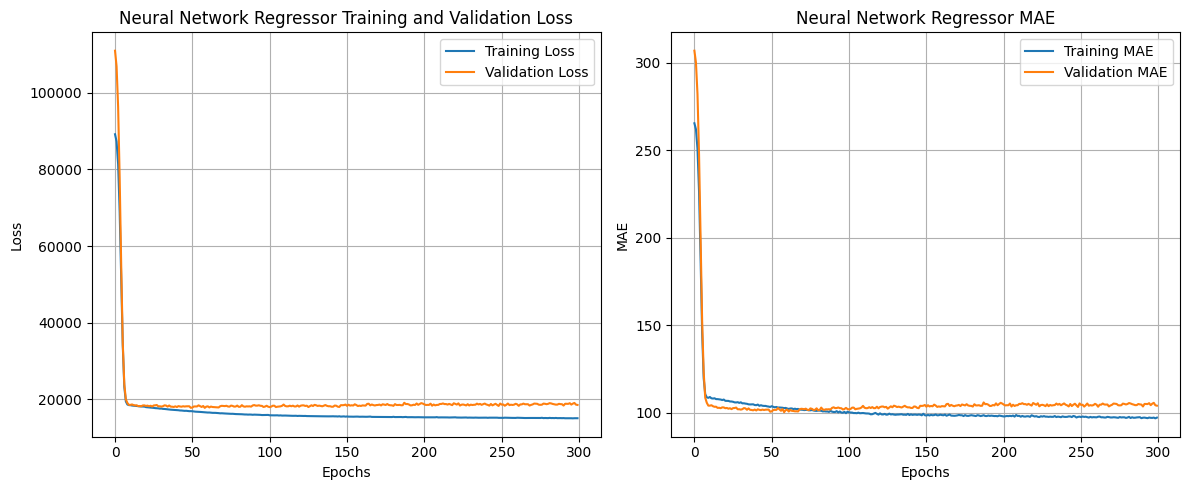

In [23]:
# Visualize Neural Network Regressor Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(reg_history.history['loss'], label='Training Loss')
plt.plot(reg_history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Regressor Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(reg_history.history['mae'], label='Training MAE')
plt.plot(reg_history.history['val_mae'], label='Validation MAE')
plt.title('Neural Network Regressor MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/nn_regressor_training_history.png', dpi=300)
plt.show()

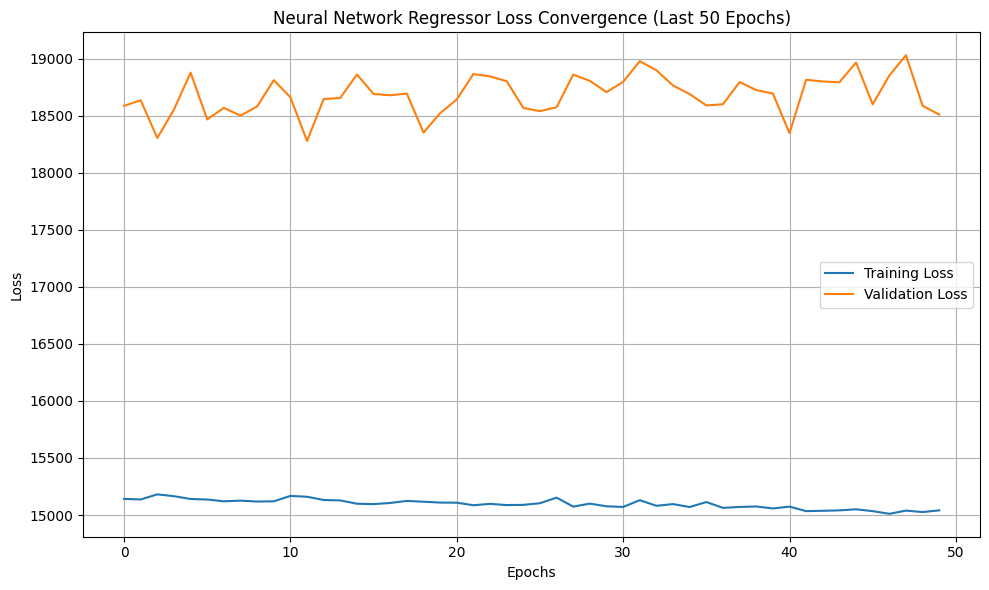

In [24]:
# Visualize Loss Convergence
plt.figure(figsize=(10, 6))

plt.plot(reg_history.history['loss'][-50:], label='Training Loss')
plt.plot(reg_history.history['val_loss'][-50:], label='Validation Loss')
plt.title('Neural Network Regressor Loss Convergence (Last 50 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/nn_loss_convergence.png', dpi=300)
plt.show()

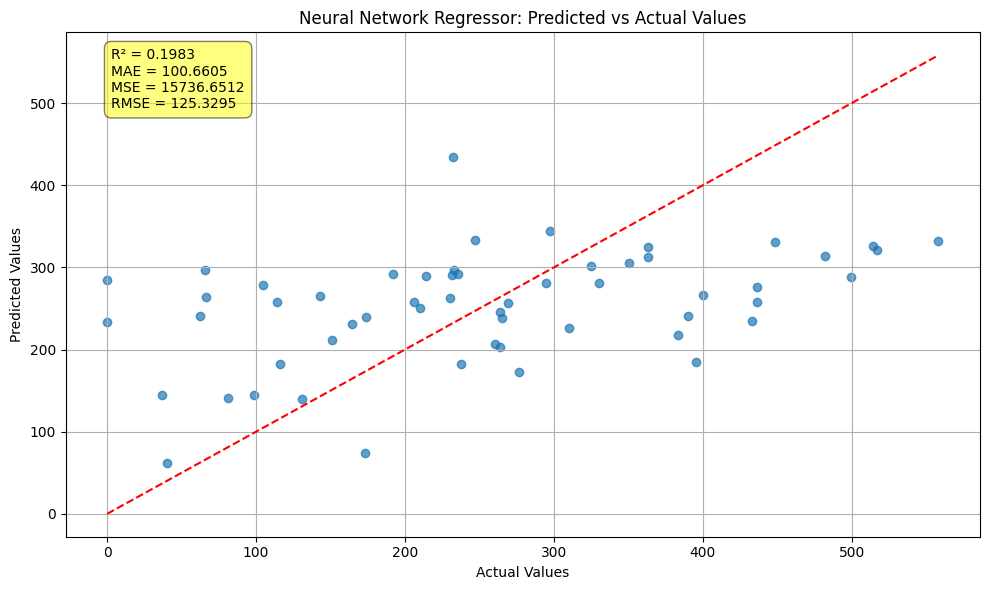

In [25]:
# Visualize Predicted vs Actual Values for Neural Network Regressor
plt.figure(figsize=(10, 6))

# Plot predicted vs actual
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.title('Neural Network Regressor: Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Add performance metrics to the plot
plt.annotate(f'R² = {m2_r2:.4f}\nMAE = {m2_mae:.4f}\nMSE = {m2_mse:.4f}\nRMSE = {m2_rmse:.4f}',
             xy=(0.05, 0.85), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.5))

plt.grid(True)
plt.tight_layout()
plt.savefig('figures/nn_predicted_vs_actual.png', dpi=300)
plt.show()

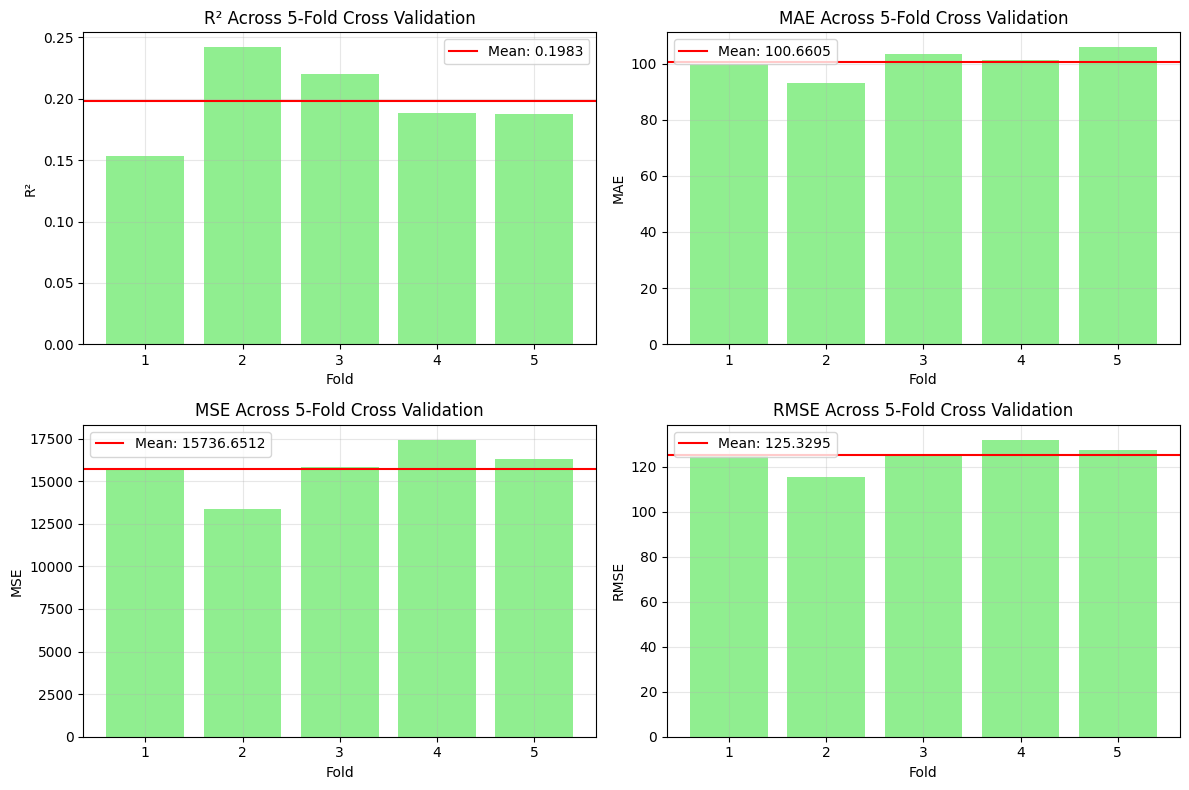

In [26]:
# Visualize Neural Network Metrics Across Cross-Validation Folds
plt.figure(figsize=(12, 8))

metrics = ['R²', 'MAE', 'MSE', 'RMSE']
metric_values = [r2_score_list2, mae_list2, mse_list2, rmse_list2]

for i, (metric, values) in enumerate(zip(metrics, metric_values), 1):
    plt.subplot(2, 2, i)
    plt.bar(range(1, 6), values, color='lightgreen')
    plt.axhline(y=np.mean(values), color='r', linestyle='-', label=f'Mean: {np.mean(values):.4f}')
    plt.title(f'{metric} Across 5-Fold Cross Validation')
    plt.xlabel('Fold')
    plt.ylabel(metric)
    plt.xticks(range(1, 6))
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/nn_cv_metrics.png', dpi=300)
plt.show()

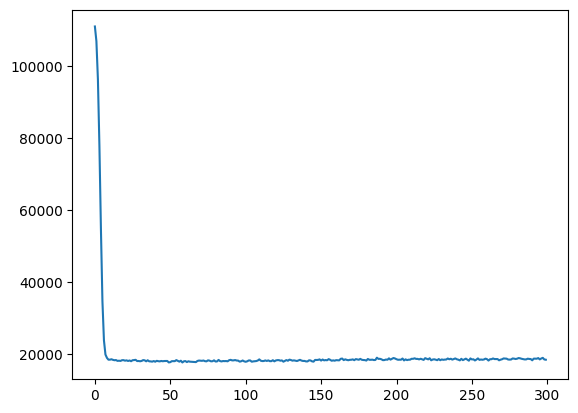

In [27]:
plt.plot(reg_history.history['val_loss'])

## Comparison Between Random Forest and Neural Network Models

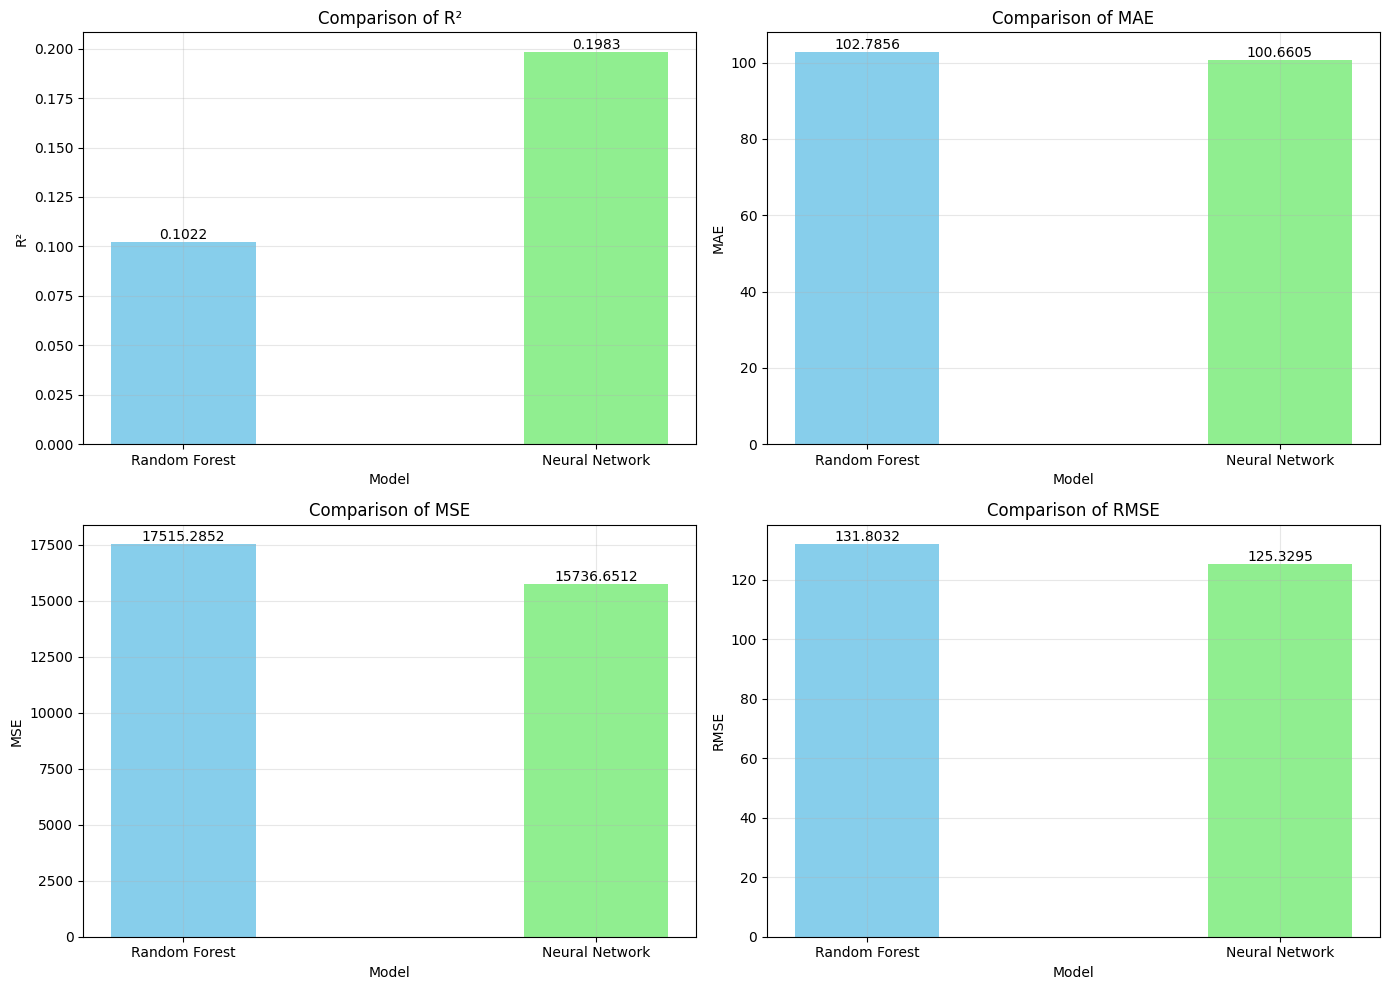

In [28]:
# Store the RF and NN results in variables for comparison
# We'll use the stored metrics from previous cells

# Calculate average metrics for both models
rf_metrics = {
    'R²': np.mean(r2_score_list), 
    'MAE': np.mean(mae_list), 
    'MSE': np.mean(mse_list), 
    'RMSE': np.mean(rmse_list)
}

# Get neural network metrics from the second run
nn_metrics = {
    'R²': np.mean(r2_score_list2), 
    'MAE': np.mean(mae_list2), 
    'MSE': np.mean(mse_list2), 
    'RMSE': np.mean(rmse_list2)
}

# Create a comparative bar chart
# Create a comparative bar chart
plt.figure(figsize=(14, 10))

metrics = ['R²', 'MAE', 'MSE', 'RMSE']
width = 0.35

rf_values = [rf_metrics[m] for m in metrics]
nn_values = [nn_metrics[m] for m in metrics]

# For each metric, we only need 2 bars (one for each model)
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    # Use x positions for 2 bars only
    x_positions = np.arange(2)
    bars = plt.bar(x_positions, [rf_values[i], nn_values[i]], width, color=['skyblue', 'lightgreen'])
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric}')
    plt.xticks(x_positions, ['Random Forest', 'Neural Network'])
    plt.grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('figures/model_comparison.png', dpi=300)
plt.show()


In [29]:
# make graphs